In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gc
import warnings 
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
from sklearn.model_selection import train_test_split
import shap

import numpy as np
import pandas as pd
import shap
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, BaggingRegressor, \
    RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, accuracy_score, \
roc_auc_score, classification_report, r2_score, precision_score, recall_score, \
log_loss, mean_squared_log_error
from catboost import CatBoostClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime as dt
import itertools
from tqdm import tqdm
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, \
recall_score, f1_score, log_loss, confusion_matrix, \
    classification_report, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingRegressor, \
BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.metrics import plot_confusion_matrix
import lightgbm as lgb 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,log_loss
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
RAND = 10

### Задача

- Цель этой задачи — предсказать исход футбольного матча на основе исторических данных о матче и игроках.

- Это решение будет полезно Laduma Analytics для расширения типов предлагаемых услуг, а также будет полезно вам. Вы сможете произвести впечатление на своих друзей точностью своих прогнозов, применяя это к предстоящим играм в вашей стране

#### Функция которая добавляет возможности в игровую статистику

In [34]:
from math import atan, sqrt

def reduce_memory_usage(df):
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type not in  ['object', 'datetime64[ns]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)

        else:
            df[col] = df[col].astype('category')
            # pass
    
    return df



def preprocess_all(path, Goals=True):
    '''
        Цель фнукции :удаления некоторых столбцов из игровой статистики и загрузки файлов  
        path:путь к данным
        Goals: bool, если True столбцы Goal_scored и Goals_coceded будут удалены.
        nx_cols: набор признаков для удаления.
    
    '''

    trgs = pd.read_csv(path+'train_game_statistics.csv')
    tsgs = pd.read_csv(path+'test_game_statistics.csv')

    cols = ["next_action"]
    if Goals:
        cols.extend(["Goals_scored", "Goals_conceded"])

    trgs = trgs.drop(
        columns=cols,
    )


    nx_cols = ['next_player',
                'next_x',
                'next_y',
                'next_team',
                'next_event_id',
                'event_id',
                'xt_value'
    ]
    trgs.drop(columns=nx_cols, inplace=True)
    tsgs.drop(columns=nx_cols, inplace=True)

    trgs = reduce_memory_usage(trgs)
    tsgs = reduce_memory_usage(tsgs)


    return trgs, tsgs 




def distance_from_goal(xy, xg=0, yg=34):
    '''
       Цель функции:рассчитать расстояние от позиции игрока до ворот
       Рассчитать расстояние от (xg, yg) до (x, y)
         по умолчанию (xg, yg) = (0, 34)
    '''
    x, y = xy

    return ((x-xg)**2 + (y-yg)**2)**.5


def calc_distance(xy1xy2):
    '''
      Цель фнукции:рассчитать евклидово расстояние b/n по двум точкам
      Вычислить расстояние от (x1, y1) до (x2, y2)
    '''
    x1, y1, x2, y2 = xy1xy2 
    return sqrt((x2 - x1)**2 + (y2 - y1)**2)


def preprocess_fe(df):
    '''
        Цель функции : добавления возможностей в игровую статистику
        df['dist_from_goal']: расстояние от цели и угол обзора из (X, Y)
        df['last y'] : Последние действия X позиции
        df['next2 x'] : следующие действия  X позиции
        prev_same_team
        df['prev_same_team'] :   какая команда выполнила последние действия
        df['next_same_team']: какая команда выполнила следующие действия
        df['prev_same_player']: какой игрок совершил последние действия
        df['next_same_player']: какой игрок совершил следующие действия
        df['prev_time_diff'] : разница во времени с начальным действием и преведущим действием
        df['event_time']: сколько времени занимает действия
        df['last_goal_dist'] : какое было расстояния от последнего действия до цели
        df['next_goal_dist'] :каково будет расстояние следующего действия от цели
        
    '''

    # сортируем игровую статистику сначала по идентификатору игры, затем по идентификатору действия
    df = df.sort_values(['Season', 'Game_ID', 'id'])
    # Удаляем ненужные столбцы менеджера и идентификатора действия
    df = df.drop(columns=['Manager', 'id'])


    # Feature Engineering
    
    # расстояние от цели и угол обзора из (X, Y)
    df['dist_from_goal'] = list(map(distance_from_goal, zip(df['X'], df['Y'])))

    # X
    df['last x'] = df.X.shift(1)   # Последние действия X позиции
    df['last2 x'] = df.X.shift(2)  # Последние 2 действия  X позиции
    df['next x'] = df.X.shift(-1)  # следующие действия  X позиции
    df['next2 x'] = df.X.shift(-2)  # следующие 2 действия X позиции

    # Y
    df['last y'] = df.Y.shift(1)   # Последние действия Y позиции
    df['last2 y'] = df.Y.shift(2)  # Последние 2 действия Y позиции
    df['next y'] = df.Y.shift(-1)  # следующие позиции Y позиции
    df['next2 y'] = df.Y.shift(-2)  # следующие 2 позиции Y позиции



    # Команда
    df['prev_same_team'] = (df['Team'].shift(1) == df.Team).astype(int)  # какая команда выполнила последние действия
    df['next_same_team'] = (df['Team'].shift(-1) == df.Team).astype(int) # какая команда выполнила следующие действия

    # Игрок
    df['prev_same_player'] = (df['Player_ID'].shift(1) == df.Player_ID).astype(int)  # какой игрок совершил последние действия
    df['next_same_player'] = (df['Player_ID'].shift(-1) == df.Player_ID).astype(int) # какой игрок совершил следующие действия

    # Время
    df['prev_time_diff'] = df['Start_minutes'] - df['Start_minutes'].shift(1) # разница во времени с начальным действием и преведущим действием
    df['event_time'] = df.End_minutes - df.Start_minutes                      # сколько времени занимает действия
    
    # Расстояния до цели
    df['last_goal_dist'] = df['dist_from_goal'].shift(1)   # какое было расстояния от последнего действия до цели
    df['next_goal_dist'] = df['dist_from_goal'].shift(-1)  # каково будет расстояние следующего действия от цели



    # Отсутствующие значения.
    ncols = ['last x', 'last2 x', 'next2 x', 'next x', 'last y', 'last2 y',
        'next2 y', 'next y', 'prev_time_diff', 'last_goal_dist',
        'next_goal_dist']
    for col in ncols:
        df[col] = df[col].fillna(-1) #для смещенных значений, поскольку у нас нет данных, давайте заполним их -1


    # не нужно добавлять действия с пасом и ударом, так как эти столбцы нам даны
    df = df[~((df.Shots == 1)|(df.Passes == 1))]

    # удаляем не нужные столбцы
    df = df.drop(columns=['Accurate passes', 'Inaccurate passes', 'Shots', 'SoT', 'Passes'])

  
    return df


**Добавляем и обрабатываем данные с помощью функции**

In [35]:
path = r'C:\Users\User\OneDrive - БФУ им. И. Канта\Рабочий стол\pet-project/'
    # change your path here

train_gs, test_gs = preprocess_all(path) # bring the files

# apply the preprocess function to both game stastics
train_gs = preprocess_fe(train_gs)
test_gs = preprocess_fe(test_gs)

train_gs.shape, test_gs.shape


((1186372, 28), (586515, 27))

In [36]:
train = pd.read_csv(path+'Train(f).csv')
test = pd.read_csv(path+'Test(f).csv')

## Feature Engineering

**Бинаризуем целевую переменную 'Score' и 'Game_ID'**

In [37]:
le=LabelEncoder()
train["Score"] = le.fit_transform(train["Score"])
score_mapping = dict(zip(le.classes_, range(len(le.classes_))))
train["Game_ID"] = le.fit_transform(train['Game_ID'])
game_mapping = dict(zip(le.classes_, range(len(le.classes_))))


train.head()

,Date,Season,Match_ID,Game_ID,Home Team,Away Team,Score
0,2017-02-15,1,1.0,218,Antennae,Andromeda,0
1,2016-09-14,1,12.0,323,Andromeda,Antennae,1
2,2016-12-12,1,13.0,254,Andromeda,Butterfly,0
3,2017-01-25,1,14.0,329,Andromeda,Cigar,0
4,2016-08-24,1,15.0,157,Andromeda,Circinus,2


In [38]:
test["Game_ID"] = le.fit_transform(test['Game_ID'])
game_mapping = dict(zip(le.classes_, range(len(le.classes_))))
test.head()

,Date,Season,Match_ID,Game_ID,Home Team,Away Team
0,2018-12-08,3,102.0,51,Antennae,Cosmos Redshift 7
1,2018-09-11,3,18.0,111,Cosmos Redshift 7,Tadpole
2,2018-09-25,3,32.0,175,Cosmos Redshift 7,Medusa Merger
3,2018-10-02,3,40.0,154,Cartwheel,Cosmos Redshift 7
4,2018-12-20,3,123.0,79,Cosmos Redshift 7,Needle


In [7]:
train.sort_values(by=['Date'])
train.head()

,Date,Season,Match_ID,Game_ID,Home Team,Away Team,Score
0,2017-02-15,1,1.0,218,Antennae,Andromeda,0
1,2016-09-14,1,12.0,323,Andromeda,Antennae,1
2,2016-12-12,1,13.0,254,Andromeda,Butterfly,0
3,2017-01-25,1,14.0,329,Andromeda,Cigar,0
4,2016-08-24,1,15.0,157,Andromeda,Circinus,2


**Объединяем test и train наборы данных, и бинаризуем категориальные и строковые данные**

In [39]:
game_map = None  # декотор индефекатора игры
team_map = None  # декотор команды

df = pd.concat([train_gs.assign(train=1), test_gs.assign(train=0)])
le = LabelEncoder()

# выбираем данные катергориального и строкового типа и закодируем их.
for c in df.select_dtypes(['object', 'category']).columns.drop('Action'):
    df[c] = le.fit_transform(df[c])
    if c == "Game_ID":
        game_map = dict(zip(range(len(le.classes_)), le.classes_))
    elif c == 'Team':
        team_map = dict(zip(range(len(le.classes_)), le.classes_))

train_gs = df[df.train == 1].drop(columns='train')
test_gs = df[df.train == 0].drop(columns=['train', 'Action'])

In [40]:
train_gs.head()

,Game_ID,Player_ID,X,Y,Team,Action,Half,Season,Opposition_Team,Start_minutes,End_minutes,dist_from_goal,last x,last2 x,next x,next2 x,last y,last2 y,next y,next2 y,prev_same_team,next_same_team,prev_same_player,next_same_player,prev_time_diff,event_time,last_goal_dist,next_goal_dist
1568122,0,320,52.31250,34.40625,14,Positional attacks,0,1,3,0.000000,0.330078,52.314077,52.31250,-1.0000,44.90625,46.0,34.40625,-1.00000,33.00000,32.59375,1,1,1,0,0.000000,0.330078,52.314077,44.917383
1568123,0,257,44.90625,33.00000,14,Positional attacks,0,1,3,0.029999,0.370117,44.917383,52.31250,52.3125,46.00000,46.0,34.40625,34.40625,32.59375,32.59375,1,1,0,1,0.029999,0.340088,52.314077,46.021490
1568124,0,257,46.00000,32.59375,14,Positional attacks,0,1,3,0.049988,0.379883,46.021490,44.90625,52.3125,46.00000,69.5,33.00000,34.40625,32.59375,67.00000,1,1,1,1,0.019989,0.329834,44.917383,46.021490
1568127,0,145,69.50000,67.00000,14,Positional attacks,0,1,3,0.080017,0.419922,76.936662,69.50000,46.0000,69.50000,69.5,67.00000,32.59375,67.00000,67.00000,1,1,1,1,0.000000,0.339844,76.936662,76.936662
1568128,0,145,69.50000,67.00000,14,Positional attacks,0,1,3,0.080017,0.419922,76.936662,69.50000,69.5000,69.50000,69.5,67.00000,67.00000,67.00000,67.00000,1,1,1,1,0.000000,0.339844,76.936662,76.936662


**Объединяем данных по статистики**

In [41]:
game_statistics = pd.concat([train_gs, test_gs])
game_statistics.shape

(1772887, 28)

In [42]:
train_test = pd.concat([train, test])
train_test.head()

,Date,Season,Match_ID,Game_ID,Home Team,Away Team,Score
0,2017-02-15,1,1.0,218,Antennae,Andromeda,0.0
1,2016-09-14,1,12.0,323,Andromeda,Antennae,1.0
2,2016-12-12,1,13.0,254,Andromeda,Butterfly,0.0
3,2017-01-25,1,14.0,329,Andromeda,Cigar,0.0
4,2016-08-24,1,15.0,157,Andromeda,Circinus,2.0


**Объединяем все данные в одну переменную для дальнешого ML**

In [43]:
df_label = game_statistics.merge(train_test, on="Game_ID")
df_label.isna().sum()

Game_ID                  0
Player_ID                0
X                        0
Y                        0
Team                     0
Action              613872
Half                     0
Season_x                 0
Opposition_Team          0
Start_minutes           10
End_minutes              0
dist_from_goal           0
last x                   0
last2 x                  0
next x                   0
next2 x                  0
last y                   0
last2 y                  0
next y                   0
next2 y                  0
prev_same_team           0
next_same_team           0
prev_same_player         0
next_same_player         0
prev_time_diff           0
event_time              10
last_goal_dist           0
next_goal_dist           0
Date                     0
Season_y                 0
Match_ID                 0
Home Team                0
Away Team                0
Score               644716
dtype: int64

- Заполняем пропуски модой

In [44]:
df_label['Score']= df_label['Score'].fillna(df_label['Score'].mode().iloc[0])

In [45]:
df_label['Start_minutes'] = df_label['Start_minutes'].fillna(df_label['Start_minutes'].mode().iloc[0])

In [46]:
df_label['event_time'] = df_label['event_time'].fillna(df_label['event_time'].mode().iloc[0])

In [47]:
df_label.isna().sum()

Game_ID                  0
Player_ID                0
X                        0
Y                        0
Team                     0
Action              613872
Half                     0
Season_x                 0
Opposition_Team          0
Start_minutes            0
End_minutes              0
dist_from_goal           0
last x                   0
last2 x                  0
next x                   0
next2 x                  0
last y                   0
last2 y                  0
next y                   0
next2 y                  0
prev_same_team           0
next_same_team           0
prev_same_player         0
next_same_player         0
prev_time_diff           0
event_time               0
last_goal_dist           0
next_goal_dist           0
Date                     0
Season_y                 0
Match_ID                 0
Home Team                0
Away Team                0
Score                    0
dtype: int64

- Удаляем не нужные признаки

In [48]:
df_label = df_label.drop(['Action','Game_ID','Player_ID','Date','Home Team', 'Away Team'],axis=1)


In [19]:
df_label.head()

,Game_ID,Player_ID,X,Y,Team,Action,Half,Season_x,Opposition_Team,Start_minutes,End_minutes,dist_from_goal,last x,last2 x,next x,next2 x,last y,last2 y,next y,next2 y,prev_same_team,next_same_team,prev_same_player,next_same_player,prev_time_diff,event_time,last_goal_dist,next_goal_dist,Date,Season_y,Match_ID,Home Team,Away Team,Score
0,0,320,52.31250,34.40625,14,Positional attacks,0,1,3,0.000000,0.330078,52.314077,52.31250,-1.0000,44.90625,46.0,34.40625,-1.00000,33.00000,32.59375,1,1,1,0,0.000000,0.330078,52.314077,44.917383,2016-11-08,1,42.0,Butterfly,Milky Way,0.0
1,0,320,52.31250,34.40625,14,Positional attacks,0,1,3,0.000000,0.330078,52.314077,52.31250,-1.0000,44.90625,46.0,34.40625,-1.00000,33.00000,32.59375,1,1,1,0,0.000000,0.330078,52.314077,44.917383,2018-11-28,3,87.0,Comet,Antennae,NaN
2,0,257,44.90625,33.00000,14,Positional attacks,0,1,3,0.029999,0.370117,44.917383,52.31250,52.3125,46.00000,46.0,34.40625,34.40625,32.59375,32.59375,1,1,0,1,0.029999,0.340088,52.314077,46.021490,2016-11-08,1,42.0,Butterfly,Milky Way,0.0
3,0,257,44.90625,33.00000,14,Positional attacks,0,1,3,0.029999,0.370117,44.917383,52.31250,52.3125,46.00000,46.0,34.40625,34.40625,32.59375,32.59375,1,1,0,1,0.029999,0.340088,52.314077,46.021490,2018-11-28,3,87.0,Comet,Antennae,NaN
4,0,257,46.00000,32.59375,14,Positional attacks,0,1,3,0.049988,0.379883,46.021490,44.90625,52.3125,46.00000,69.5,33.00000,34.40625,32.59375,67.00000,1,1,1,1,0.019989,0.329834,44.917383,46.021490,2016-11-08,1,42.0,Butterfly,Milky Way,0.0


- Проверяем пропуски

In [49]:
df_label.isna().sum()

X                   0
Y                   0
Team                0
Half                0
Season_x            0
Opposition_Team     0
Start_minutes       0
End_minutes         0
dist_from_goal      0
last x              0
last2 x             0
next x              0
next2 x             0
last y              0
last2 y             0
next y              0
next2 y             0
prev_same_team      0
next_same_team      0
prev_same_player    0
next_same_player    0
prev_time_diff      0
event_time          0
last_goal_dist      0
next_goal_dist      0
Season_y            0
Match_ID            0
Score               0
dtype: int64

# Modeling

***Показателем оценки для этой задачи является log loss***

**Метрики для задачи мултиклассфикации**

In [25]:
def get_metrics_multiclass(y_test_bin, y_test, y_pred, y_prob, name,
                           type_multi):
    """
    y_test_bin - бинаризованные тестовые метки класса
    y_test - метки класса без бинаризации
    y_prob - предсказанные вероятности классов
    name - название модели/подхода
    type_multi - тип многоклассовой классификации для ROC-AUC (ovo/ovr)
    """

    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    df_metrics['ROC_AUC'] = roc_auc_score(y_test_bin,
                                          y_prob,
                                          multi_class=type_multi)
    df_metrics['Precision_micro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='micro')
    df_metrics['Precision_macro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='macro')
    df_metrics['Recall_micro'] = recall_score(y_test, y_pred, average='micro')
    df_metrics['Recall_macro'] = recall_score(y_test, y_pred, average='macro')
    df_metrics['F1_micro'] = f1_score(y_test, y_pred, average='micro')
    df_metrics['F1_macro'] = f1_score(y_test, y_pred, average='macro')
    df_metrics['Logloss'] = log_loss(y_test, y_prob)

    return df_metrics

**Проверка на переобучаемость модлеи**

In [26]:
def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
    """
    Проверка на overfitting для 
    """
    y_pred_train = model.predict_proba(X_train)
    y_pred_test = model.predict_proba(X_test)
    value_train = metric_fun(y_train, y_pred_train)
    value_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % value_train)
    print(f'{metric_fun.__name__} test: %.3f' % value_test)
    print(f'delta = {(abs(value_train - value_test)/value_test*100):.1f} %')
    

**Разбиения данных**

In [27]:
X = df_label.drop('Score', axis=1)
y = df_label['Score'].values

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=RAND)
n_classes = len(set(y))
y_test_bin = label_binarize(y_test, classes=list(set(y)))

## Baseline 

**LogisticRegression**

In [24]:
lr=LogisticRegression()
lr.fit(X_train,y_train)
#Predictiing on Test Set
y_pred = lr.predict_proba(X_test)
y_score = lr.predict_proba(X_test)
print(log_loss(y_test,y_pred))


0.7972837478927675



- Проверка на переобучаемость модлеи

In [29]:
check_overfitting(lr, X_train, y_train, X_test, y_test, log_loss)



log_loss train: 0.797
log_loss test: 0.797
delta = 0.1 %


**XGBClassifier**

In [26]:
xgb=XGBClassifier(random_state=RAND, n_estimators=50)
xgb.fit(X_train,y_train)
#Predictiing on Test Set
y_pred = xgb.predict_proba(X_test)
y_score = lr.predict_proba(X_test)
print(log_loss(y_test,y_pred))



[23:04:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.12532562718588183


- Проверка на переобучаемость модлеи

In [30]:
check_overfitting(xgb, X_train, y_train, X_test, y_test, log_loss)


log_loss train: 0.125
log_loss test: 0.125
delta = 0.5 %


**RandomForestClassifier**

In [33]:
clf = RandomForestClassifier(n_estimators=30 , random_state=RAND)
clf.fit(X_train,y_train)
#Predictiing on Test Set
y_pred = clf.predict_proba(X_test)
y_score = clf.predict_proba(X_test)
print(log_loss(y_test,y_pred))

0.07536936061053792


- Проверка на переобучаемость модлеи

In [35]:
check_overfitting(clf, X_train, y_train, X_test, y_test, log_loss)


log_loss train: 0.026
log_loss test: 0.075
delta = 65.4 %


**LGBMClassifier**

In [31]:

lgb = LGBMClassifier(n_estimators=1000, random_state=RAND,objective='multiclass')
eval_set = [(X_test, y_test)]

lgb.fit(X_train,
        y_train,
        eval_metric='multi_logloss',
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100,
       )

y_pred = lgb.predict_proba(X_test)
y_score = lgb.predict_proba(X_test)

In [32]:
print(log_loss(y_test,y_pred))


2.2501173801362876e-05


- Проверка на переобучаемость модлеи

In [33]:
check_overfitting(lgb, X_train, y_train, X_test, y_test, log_loss)


log_loss train: 0.000
log_loss test: 0.000
delta = 99.9 %


**CatBoostClassifier**

In [33]:
cat = CatBoostClassifier(n_estimators=1000,
                        allow_writing_files=False,
                        random_state=RAND,
                        eval_metric="MultiClass")
                        
                        
eval_set = [(X_test, y_test)]

cat.fit(X_train,
        y_train,
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)

y_pred = cat.predict_proba(X_test)
y_score = cat.predict_proba(X_test)



KeyboardInterrupt



In [35]:
print(log_loss(y_test,y_pred))

0.00865730127501462


- Проверка на переобучаемость модлеи

In [36]:
check_overfitting(cat, X_train, y_train, X_test, y_test, log_loss)


log_loss train: 0.009
log_loss test: 0.009
delta = 0.6 %


## Tuning

**LogisticRegression**

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
# Задание пространства гиперпараметров для поиска
param_dist = {
    'C': uniform(loc=0, scale=1),  # Равномерное распределение от 0 до 1
    'max_iter': [100, 500, 1000],  # Заданные значения
}
lr = LogisticRegression()

# Создание объекта RandomizedSearchCV
random_search3 = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    scoring='neg_log_loss',
    n_iter=10,  # Количество итераций случайного поиска
    cv=5,  # Количество фолдов в кросс-валидации
    random_state=12
)


In [94]:
random_search3.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002793DD85E80>,
                                        'max_iter': [100, 500, 1000]},
                   random_state=12, scoring='neg_log_loss')

In [95]:
print("Лучшие гиперпараметры:", random_search3.best_params_)
print("Лучший результат:", random_search3.best_score_)

Лучшие гиперпараметры: {'C': 0.8733871524282918, 'max_iter': 1000}
Лучший результат: -0.7881938906927392


In [97]:
# Предсказание на тестовом наборе данных с использованием модели с наилучшими гиперпараметрами
y_pred = random_search3.predict_proba(X_test)

In [98]:
# Вывод значения log loss
print("Log Loss:", log_loss(y_test, y_pred))

Log Loss: 0.789008069721617


In [100]:
lr=LogisticRegression(C=0.87,max_iter=1000)
lr.fit(X_train,y_train)
#Predictiing on Test Set
y_pred = lr.predict_proba(X_test)
print(log_loss(y_test,y_pred))

0.7894714507625957


- Проверка на переобучаемость модлеи

In [101]:
check_overfitting(lr, X_train, y_train, X_test, y_test, log_loss)


log_loss train: 0.789
log_loss test: 0.789
delta = 0.1 %


**XGBClassifier**

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'colsample_bytree': [0.2, 0.4, 0.6],
    'subsample': [0.6, 0.8, 1.0],
}

xgb = XGBClassifier(random_state=12)
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=10, scoring='neg_log_loss', cv=3, random_state=42)


In [34]:
%%time
random_search.fit(X_train, y_train)


CPU times: total: 4h 39min 41s
Wall time: 41min 50s


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_leaves=None,
                                   

In [35]:
print("Лучшие гиперпараметры:", random_search.best_params_)
print("Лучший результат:", random_search.best_score_)

Лучшие гиперпараметры: {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Лучший результат: -0.40075155193168954


In [36]:
# Предсказание на тестовом наборе данных с использованием модели с наилучшими гиперпараметрами
y_pred = random_search.predict_proba(X_test)

In [37]:
# Вывод значения log loss
print("Log Loss:", log_loss(y_test, y_pred))

Log Loss: 0.4020246584225856


In [69]:
xgb=XGBClassifier(n_estimators=50 , max_depth=5, learning_rate=0.2,colsample_bytree=0.6,
                  random_state=12,subsample=1)
xgb.fit(X_train,y_train)
#Predictiing on Test Set
y_pred = xgb.predict_proba(X_test)
y_socre = xgb.predict_proba(X_test)
print(log_loss(y_test,y_pred))



0.4020246584225856


- Проверка на переобучаемость модлеи

In [40]:
check_overfitting(xgb, X_train, y_train, X_test, y_test, log_loss)


log_loss train: 0.401
log_loss test: 0.402
delta = 0.4 %


**RandomForestClassifier**

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV



# Задаем сетку параметров для подбора
param_grid = {
    'n_estimators': [100, 120, 150],  # Параметр для количества деревьев в лесу
    'max_depth': [2, 4, 6],  # Параметр для максимальной глубины деревьев
    'max_features': [0.6, 0.8, 1.0]  # Параметр для доли признаков используемых при разделении
}

# Создаем экземпляр модели RandomForestClassifier
rfc = RandomForestClassifier(random_state=12)
# Создаем экземпляр RandomizedSearchCV для подбора параметров
random_search1 = RandomizedSearchCV(rfc, param_distributions=param_grid, n_iter=10,  scoring='neg_log_loss', cv=3, random_state=42)


In [54]:
%%time
random_search1.fit(X_train, y_train)

CPU times: total: 4h 49min 43s
Wall time: 4h 50min 7s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12),
                   param_distributions={'max_depth': [2, 4, 6],
                                        'max_features': [0.6, 0.8, 1.0],
                                        'n_estimators': [100, 120, 150]},
                   random_state=42, scoring='neg_log_loss')

In [56]:
print("Лучшие гиперпараметры:", random_search1.best_params_)
print("Лучший результат:", random_search1.best_score_)

Лучшие гиперпараметры: {'n_estimators': 100, 'max_features': 0.8, 'max_depth': 6}
Лучший результат: -0.6125530787508939


In [57]:
# Предсказание на тестовом наборе данных с использованием модели с наилучшими гиперпараметрами
y_pred = random_search1.predict_proba(X_test)

In [58]:
# Вывод значения log loss
print("Log Loss:", log_loss(y_test, y_pred))

Log Loss: 0.6144583217555865


In [59]:
rfc = RandomForestClassifier(n_estimators=100 , random_state=12,max_depth=6,max_features=0.8)
rfc.fit(X_train,y_train)
#Predictiing on Test Set
y_pred = rfc.predict_proba(X_test)
y_score = rfc.predict_proba(X_test)
print(log_loss(y_test,y_pred))

0.6144583217555865


- Проверка на переобучаемость модлеи

In [60]:
check_overfitting(rfc, X_train, y_train, X_test, y_test, log_loss)


log_loss train: 0.613
log_loss test: 0.614
delta = 0.2 %


**LGBMClassifier**

In [81]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint



# Задание пространства гиперпараметров для поиска
param_dist = {
    'n_estimators': sp_randint(50, 100), # Случайное целое значение от 50 до 200
    'max_depth': sp_randint(3, 10), # Случайное целое значение от 3 до 10
    'learning_rate': [0.01, 0.05, 0.1], # Заданные значения
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0], # Заданные значения
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # Заданные значения
}
# Создание модели LGBMClassifier
lgbm = LGBMClassifier(random_state=12)

# Создание объекта RandomizedSearchCV
random_search2 = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    scoring='neg_log_loss',
    n_iter=10, # Количество итераций случайного поиска
    cv=2, # Количество фолдов в кросс-валидации
    random_state=12
)

In [82]:
%%time
random_search2.fit(X_train, y_train)


CPU times: total: 26min 5s
Wall time: 3min 46s


RandomizedSearchCV(cv=2, estimator=LGBMClassifier(random_state=12),
                   param_distributions={'colsample_bytree': [0.2, 0.4, 0.6, 0.8,
                                                             1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002794BF7D490>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002794BF63400>,
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=12, scoring='neg_log_loss')

In [84]:
print("Лучшие гиперпараметры:", random_search2.best_params_)
print("Лучший результат:", random_search2.best_score_)

Лучшие гиперпараметры: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 99, 'subsample': 0.8}
Лучший результат: -0.10788136954257932


In [85]:
# Предсказание на тестовом наборе данных с использованием модели с наилучшими гиперпараметрами
y_pred = random_search2.predict_proba(X_test)

In [86]:
# Вывод значения log loss
print("Log Loss:", log_loss(y_test, y_pred))

Log Loss: 0.1080691814259357


In [87]:
lgbm = LGBMClassifier(n_estimators=99, max_depth=8, learning_rate=0.1, colsample_bytree=0.8,
                      random_state=12, subsample=0.8)
lgbm.fit(X_train, y_train)

y_pred = lgbm.predict_proba(X_test)
y_score = lgbm.predict_proba(X_test)

print(log_loss(y_test, y_pred))

0.1080691814259357


- Проверка на переобучаемость модлеи

In [88]:
check_overfitting(lgbm, X_train, y_train, X_test, y_test, log_loss)


log_loss train: 0.108
log_loss test: 0.108
delta = 0.5 %


### Анализ важных признаков с помощью библиотеки Shap

**Модель для анализа LGBMClassifier**

In [102]:
explainer = shap.TreeExplainer(lgbm)

In [103]:
shap_values = explainer.shap_values(X_test)

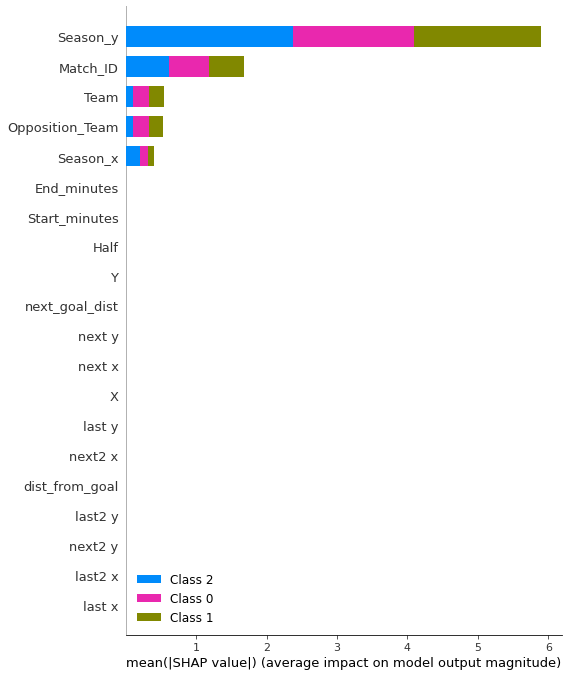

In [104]:
shap.summary_plot(shap_values, X_test)

**Вывод по признакам**
-    Season_x и Season_y: Эти признаки, вероятно, относятся к информации о текущем и следующем сезонах соответственно. Они могут быть важными для модели в определении исхода матча, поскольку результаты команд могут различаться в зависимости от текущего и следующего сезонов.

-   Match_Id: Этот признак представляет индентификационный номер матча и может быть полезен для модели в учете уникальности каждого матча и возможного влияния конкретных матчей на исходы.

-    Opposition_Team и Team: Эти признаки относятся к командам-противникам и команде игрока соответственно. Они могут быть важными, поскольку результаты матчей могут зависеть от противника и собственной команды.

# StackingClassifier
- **Модель - LogisticRegression**
- **Модель - RandomForestClassifier**
- **Модель - LGBMClassifier**

In [31]:

lr=LogisticRegression(C=0.1,max_iter=1000)
rfc = RandomForestClassifier(n_estimators=120 , random_state=12,max_depth=2,max_features=0.8)
lgbm = LGBMClassifier(n_estimators=50, max_depth=4, learning_rate=0.08, colsample_bytree=0.2,
                      random_state=12, subsample=0.8, num_class=1)
clf1 = CalibratedClassifierCV(base_estimator=lr, method='isotonic', cv=3)
clf2 = CalibratedClassifierCV(base_estimator=rfc, method='isotonic', cv=3)
clf3 = CalibratedClassifierCV(base_estimator=lgbm, method='isotonic', cv=3)



In [32]:
estimators = [('lgbm', clf1), ('rfc', clf2), ('lr', clf3)]

stf_cv = StratifiedKFold(n_splits=5)
meta = StackingClassifier(
    estimators=estimators,
    cv=stf_cv,
    final_estimator=LogisticRegression(random_state=RAND))

In [33]:
%%time
meta.fit(X_train, y_train)

CPU times: total: 4h 31min 6s
Wall time: 2h 38min 30s


StackingClassifier(cv=StratifiedKFold(n_splits=5,
        random_state=RandomState(MT19937) at 0x224F4D29A40, shuffle=False),
                   estimators=[('lgbm',
                                CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.1,
                                                                                         max_iter=1000),
                                                       cv=3,
                                                       method='isotonic')),
                               ('rfc',
                                CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=2,
                                                                                             max_features=0.8,
                                                                                             n_estimators=120,
                                                                                             random_state=12),
                  

In [34]:
check_overfitting(meta, X_train, y_train, X_test, y_test, log_loss)


log_loss train: 0.529
log_loss test: 0.532
delta = 0.7 %


In [35]:
y_pred = meta.predict_proba(X_test)
y_score = meta.predict_proba(X_test)

print(log_loss(y_test, y_pred))

0.5322167946492792
